In [1]:
# Reference - https://gist.github.com/gkhayes/3d154e0505e31d6367be22ed3da2e955


In [2]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

## Tile Coding 
(Rich Sutton's Implementation)

In [ ]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles



In [ ]:
class MountainCarTileCoder:
    # Taken from the MOOC
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same
                            
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles 
        self.iht = IHT(iht_size)
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountain car environment
        and returns a numpy array of active tiles.
        
        Arguments:
          Num    Observation               Min            Max
          0      Car Position              -1.2           0.6
          1      Car Velocity              -0.07          0.07
        
        returns:
        tiles -- np.array, active tiles
        
        """
        
        ### Use the ranges above and scale the angle and angular velocity between [0, 1]
        # then multiply by the number of tiles so they are scaled between [0, self.num_tiles]
        
        position_scaled = ((position + 1.2) / (0.6 + 1.2)) * self.num_tiles
        velocity_scaled = ((velocity + 0.07) / (0.07 + 0.07)) * self.num_tiles

        # Get tiles by calling tc.tileswrap method
        # wrapwidths specify which dimension to wrap over and its wrapwidth
        ts = tiles(self.iht, self.num_tilings, [position_scaled, velocity_scaled])
                    
        return np.array(ts)

## Adam optimizer

In [ ]:
class Adam:
    # Taken from MOOC
    # Work Required: Yes. Fill in the initialization for self.m and self.v (~4 Lines).
    def __init__(self, ftr_vec_size, optimizer_info):
        self.ftr_vec_size = ftr_vec_size

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")
        
        # Initialize Adam algorithm's m and v
        self.m = np.zeros(self.ftr_vec_size)
        self.v = np.zeros(self.ftr_vec_size)
            
        # Notice that to calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        # the time step t. We can calculate these powers using an incremental product. At initialization then, 
        # beta_m_product and beta_v_product should be ...? (Note that timesteps start at 1 and if we were to 
        # start from 0, the denominator would be 0.)
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
    
    # Work Required: Yes. Fill in the weight updates (~5-7 lines).
    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the 
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        self.m = self.beta_m * self.m + (1 - self.beta_m) * td_errors_times_gradients
        self.v = self.beta_v * self.v + (1 - self.beta_v) * (np.square(td_errors_times_gradients))
        m_hat = self.m / (1 - self.beta_m_product)
        v_hat = self.v / (1 - self.beta_v_product)
        weight_update = (self.step_size / (np.sqrt(v_hat) + self.epsilon)) * m_hat
                
        weights += weight_update
        # Notice that to calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        ### update self.beta_m_product and self.beta_v_product
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights



## Sarsa Agent, fixed alpha

In [ ]:
class SarsaAgent():
    """Class for a Sarsa agent"""

    def __init__(self):
        """Leave agent initialization for agent_init method"""

        self.last_action = None
        self.last_state = None
        self.epsilon = None
        #self.target_epsilon = None
        self.gamma = None
        self.w = None
        self.alpha = None
        #self.initial_weights = None
        self.num_actions = None
        #self.features = None
        self.terminate = False
        #self.dimensions = 0

    def agent_init(self, agent_info={}):
        """Set up the agent at the beginning of the experiment"""

        self.epsilon = agent_info.get("epsilon", 0.3)
        #self.target_epsilon = agent_info.get("target_epsilon", 0.3)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.1)
        #self.initial_weights = agent_info.get("initial_weights", 0.0)
        #self.num_states = agent_info.get("num_states", 4)
        self.num_actions = agent_info.get("num_actions", 2)
        #self.dimensions = agent_info.get("dimensions", 2)
        #self.features = agent_info.get("features", np.array(
            #[[[0, 1], [0.8, 0]], [[0, 0], [0.8, 0]], [[0, 0], [-1, 0]], [[0, 1], [-1, 0]]]))

        self.is_testing = agent_info.get("is_testing", False)
        self.num_tiles = agent_info.get('num_tiles', 8)
        self.num_tilings = agent_info.get('num_tilings', 8)

        self.w = np.zeros(self.num_tiles ** 2 * self.num_tilings * self.num_actions)
        self.tile_coder = MountainCarTileCoder(iht_size=self.num_tiles ** 2 * self.num_tilings, num_tilings=self.num_tilings,
                                               num_tiles=self.num_tiles)
        
        np.random.seed(agent_info.get('seed', 1))

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """

        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

    def select_action(self, state):
        """
        Selects an action using epsilon greedy
        Args:
        state - (float, float) the current state (position, velocity)
        Returns:
        (chosen_action, max_action_value) - (int, float), tuple of the chosen action
                                        (epsilon greedy behaviour) and the max action value (target update)
        """

        action_values = []
        chosen_action = None
        for action in range(self.num_actions):
            active_tiles = self.tile_coder.get_tiles(state[0], state[1]) + action * (self.num_tiles**2 * self.num_tilings)
            action_val = np.sum(self.w[active_tiles])
            action_values.append(action_val)
        
        #action_values = values.tolist()

        if self.is_testing:
            chosen_action = self.argmax(action_values)
        else:

            if np.random.random() < self.epsilon:
                chosen_action = np.random.choice(self.num_actions)
            else:
                chosen_action = self.argmax(action_values)
        # ----------------

        return chosen_action, action_values[chosen_action]

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (int): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

        current_action, _ = self.select_action(state)
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (float, float): the (position, velocity) observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # select action based on new state
        current_action, epsilon_q_val = self.select_action(state)
        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform update to weights
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            self.w += self.alpha * (reward + self.gamma * epsilon_q_val - last_q_val) * grad
        # update previous state, action
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform the last update
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            self.w += self.alpha * (reward - last_q_val) * grad


## Sarsa agent, adam optimizer

In [ ]:
class SarsaAgent_adam():
    """Class for a Sarsa agent"""

    def __init__(self):
        """Leave agent initialization for agent_init method"""

        self.last_action = None
        self.last_state = None
        self.epsilon = None
        #self.target_epsilon = None
        self.gamma = None
        self.w = None
        self.alpha = None
        #self.initial_weights = None
        self.num_actions = None
        #self.features = None
        self.terminate = False
        #self.dimensions = 0

    def agent_init(self, agent_info={}):
        """Set up the agent at the beginning of the experiment"""

        self.epsilon = agent_info.get("epsilon", 0.3)
        #self.target_epsilon = agent_info.get("target_epsilon", 0.3)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.1)
        #self.initial_weights = agent_info.get("initial_weights", 0.0)
        #self.num_states = agent_info.get("num_states", 4)
        self.num_actions = agent_info.get("num_actions", 2)
        #self.dimensions = agent_info.get("dimensions", 2)
        #self.features = agent_info.get("features", np.array(
            #[[[0, 1], [0.8, 0]], [[0, 0], [0.8, 0]], [[0, 0], [-1, 0]], [[0, 1], [-1, 0]]]))

        self.is_testing = agent_info.get("is_testing", False)
        self.num_tiles = agent_info.get('num_tiles', 8)
        self.num_tilings = agent_info.get('num_tilings', 8)

        self.w = np.zeros(self.num_tiles ** 2 * self.num_tilings * self.num_actions)
        self.tile_coder = MountainCarTileCoder(iht_size=self.num_tiles ** 2 * self.num_tilings, num_tilings=self.num_tilings,
                                               num_tiles=self.num_tiles)
        
        np.random.seed(agent_info.get('seed', 1))

        self.adam = Adam(self.num_tiles ** 2 * self.num_tilings * self.num_actions,
                         {'step_size': 0.001,
                          'beta_m': 0.9,
                          'beta_v': 0.999,
                          'epsilon': 0.00000001})

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """

        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

    def select_action(self, state):
        """
        Selects an action using epsilon greedy
        Args:
        state - (float, float) the current state (position, velocity)
        Returns:
        (chosen_action, max_action_value) - (int, float), tuple of the chosen action
                                        (epsilon greedy behaviour) and the max action value (target update)
        """

        action_values = []
        chosen_action = None
        for action in range(self.num_actions):
            active_tiles = self.tile_coder.get_tiles(state[0], state[1]) + action * (self.num_tiles**2 * self.num_tilings)
            action_val = np.sum(self.w[active_tiles])
            action_values.append(action_val)
        
        #action_values = values.tolist()

        if self.is_testing:
            chosen_action = self.argmax(action_values)
        else:

            if np.random.random() < self.epsilon:
                chosen_action = np.random.choice(self.num_actions)
            else:
                chosen_action = self.argmax(action_values)
        # ----------------

        return chosen_action, action_values[chosen_action]

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (int): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

        current_action, _ = self.select_action(state)
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (float, float): the (position, velocity) observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # select action based on new state
        current_action, epsilon_q_val = self.select_action(state)
        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform update to weights
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            td_error = reward + self.gamma * epsilon_q_val - last_q_val
            td_error_times_grad = td_error * grad
            self.w = self.adam.update_weights(self.w, td_error_times_grad)
        # update previous state, action
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform the last update
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            td_error = reward - last_q_val
            td_error_times_grad = td_error * grad
            self.w = self.adam.update_weights(self.w, td_error_times_grad)


## Q-learning agent, fixed alpha

In [ ]:
class QlearningAgent():
    """Class for a q-learning agent"""

    def __init__(self):
        """Leave agent initialization for agent_init method"""

        self.last_action = None
        self.last_state = None
        self.epsilon = None
        #self.target_epsilon = None
        self.gamma = None
        self.w = None
        self.alpha = None
        #self.initial_weights = None
        self.num_actions = None
        #self.features = None
        self.terminate = False
        #self.dimensions = 0

    def agent_init(self, agent_info={}):
        """Set up the agent at the beginning of the experiment"""

        self.epsilon = agent_info.get("epsilon", 0.3)
        #self.target_epsilon = agent_info.get("target_epsilon", 0.3)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.1)
        #self.initial_weights = agent_info.get("initial_weights", 0.0)
        #self.num_states = agent_info.get("num_states", 4)
        self.num_actions = agent_info.get("num_actions", 2)
        #self.dimensions = agent_info.get("dimensions", 2)
        #self.features = agent_info.get("features", np.array(
            #[[[0, 1], [0.8, 0]], [[0, 0], [0.8, 0]], [[0, 0], [-1, 0]], [[0, 1], [-1, 0]]]))

        self.is_testing = agent_info.get("is_testing", False)
        self.num_tiles = agent_info.get('num_tiles', 8)
        self.num_tilings = agent_info.get('num_tilings', 8)

        self.w = np.zeros(self.num_tiles ** 2 * self.num_tilings * self.num_actions)
        self.tile_coder = MountainCarTileCoder(iht_size=self.num_tiles ** 2 * self.num_tilings, num_tilings=self.num_tilings,
                                               num_tiles=self.num_tiles)
        
        np.random.seed(agent_info.get('seed', 1))

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """

        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

    def select_action(self, state):
        """
        Selects an action using epsilon greedy
        Args:
        state - (float, float) the current state (position, velocity)
        Returns:
        (chosen_action, max_action_value) - (int, float), tuple of the chosen action
                                        (epsilon greedy behaviour) and the max action value (target update)
        """

        action_values = []
        chosen_action = None
        for action in range(self.num_actions):
            active_tiles = self.tile_coder.get_tiles(state[0], state[1]) + action * (self.num_tiles**2 * self.num_tilings)
            action_val = np.sum(self.w[active_tiles])
            action_values.append(action_val)
        
        #action_values = values.tolist()

        if self.is_testing:
            chosen_action = self.argmax(action_values)
        else:

            if np.random.random() < self.epsilon:
                chosen_action = np.random.choice(self.num_actions)
            else:
                chosen_action = self.argmax(action_values)
        # ----------------

        return chosen_action, max(action_values)

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (int): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

        current_action, _ = self.select_action(state)
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (float, float): the (position, velocity) observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # select action based on new state
        current_action, max_q_val = self.select_action(state)
        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform update to weights
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            self.w += self.alpha * (reward + self.gamma * max_q_val - last_q_val) * grad
        # update previous state, action
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform the last update
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            self.w += self.alpha * (reward - last_q_val) * grad


## Q-learning, adam optimizer

In [ ]:
class QlearningAgent_adam():
    """Class for a Sarsa agent"""

    def __init__(self):
        """Leave agent initialization for agent_init method"""

        self.last_action = None
        self.last_state = None
        self.epsilon = None
        #self.target_epsilon = None
        self.gamma = None
        self.w = None
        self.alpha = None
        #self.initial_weights = None
        self.num_actions = None
        #self.features = None
        self.terminate = False
        #self.dimensions = 0

    def agent_init(self, agent_info={}):
        """Set up the agent at the beginning of the experiment"""

        self.epsilon = agent_info.get("epsilon", 0.3)
        #self.target_epsilon = agent_info.get("target_epsilon", 0.3)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.1)
        #self.initial_weights = agent_info.get("initial_weights", 0.0)
        #self.num_states = agent_info.get("num_states", 4)
        self.num_actions = agent_info.get("num_actions", 2)
        #self.dimensions = agent_info.get("dimensions", 2)
        #self.features = agent_info.get("features", np.array(
            #[[[0, 1], [0.8, 0]], [[0, 0], [0.8, 0]], [[0, 0], [-1, 0]], [[0, 1], [-1, 0]]]))

        self.is_testing = agent_info.get("is_testing", False)
        self.num_tiles = agent_info.get('num_tiles', 8)
        self.num_tilings = agent_info.get('num_tilings', 8)

        self.w = np.zeros(self.num_tiles ** 2 * self.num_tilings * self.num_actions)
        self.tile_coder = MountainCarTileCoder(iht_size=self.num_tiles ** 2 * self.num_tilings, num_tilings=self.num_tilings,
                                               num_tiles=self.num_tiles)
        
        np.random.seed(agent_info.get('seed', 1))

        self.adam = Adam(self.num_tiles ** 2 * self.num_tilings * self.num_actions,
                         {'step_size': 0.001,
                          'beta_m': 0.9,
                          'beta_v': 0.999,
                          'epsilon': 0.00000001})

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """

        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

    def select_action(self, state):
        """
        Selects an action using epsilon greedy
        Args:
        state - (float, float) the current state (position, velocity)
        Returns:
        (chosen_action, max_action_value) - (int, float), tuple of the chosen action
                                        (epsilon greedy behaviour) and the max action value (target update)
        """

        action_values = []
        chosen_action = None
        for action in range(self.num_actions):
            active_tiles = self.tile_coder.get_tiles(state[0], state[1]) + action * (self.num_tiles**2 * self.num_tilings)
            action_val = np.sum(self.w[active_tiles])
            action_values.append(action_val)
        
        #action_values = values.tolist()

        if self.is_testing:
            chosen_action = self.argmax(action_values)
        else:

            if np.random.random() < self.epsilon:
                chosen_action = np.random.choice(self.num_actions)
            else:
                chosen_action = self.argmax(action_values)
        # ----------------

        return chosen_action, max(action_values)

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (int): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

        current_action, _ = self.select_action(state)
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (float, float): the (position, velocity) observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # select action based on new state
        current_action, max_q_val = self.select_action(state)
        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform update to weights
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            td_error = reward + self.gamma * max_q_val - last_q_val
            td_error_times_grad = td_error * grad
            self.w = self.adam.update_weights(self.w, td_error_times_grad)
        # update previous state, action
        self.last_state = state
        self.last_action = current_action
        return current_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # get q hat value for previous state-action pair
        prev_tiles = self.tile_coder.get_tiles(self.last_state[0], self.last_state[1]) + self.last_action * (self.num_tiles**2 * self.num_tilings)
        last_q_val = np.sum(self.w[prev_tiles])
        # perform the last update
        if not self.is_testing:
            grad = np.zeros(self.w.shape)
            grad[prev_tiles] = 1.0
            td_error = reward - last_q_val
            td_error_times_grad = td_error * grad
            self.w = self.adam.update_weights(self.w, td_error_times_grad)



## Experiment run functions

In [ ]:
def run_agent(agent_class, agent_info, run_info):
    num_runs = run_info.get('num_runs', 100)
    num_episodes = run_info.get('num_episodes', 1000)
    max_steps = run_info.get('max_steps', 1000)
    run_steps = dict()

    env = gym.make('MountainCar-v0')

    agent = agent_class()

    for run in tqdm(range(num_runs), desc="Runs"):
        env.seed(run)
        agent_info['seed'] = run
        agent.agent_init(agent_info)

        run_steps[run] = []
        
        for episode in range(num_episodes):
            steps = 0

            state = env.reset()
            action = agent.agent_start(state)

            # continue taking steps
            while True:
                # get next state and reward from agent's action in environmnet
                state, reward, done, info = env.step(action)
                steps += 1
                # if done we end episode
                if done:
                    # but we only update if we reached goal state, not hit max steps
                    if steps < max_steps:
                        agent.agent_end(reward)
                    break

                # if episode is not done agent takes another step
                action = agent.agent_step(reward, state)
            
            # after episode ends we add number of steps to list of step counts
            run_steps[run].append(steps)
        
        # after run ends just continue to next run
    
    # after all runs end return run_steps dict
    return run_steps


In [ ]:
def run_agent_random(agent_class, agent_info, run_info):
    num_runs = run_info.get('num_runs', 100)
    num_episodes = run_info.get('num_episodes', 1000)
    max_steps = run_info.get('max_steps', 1000)
    run_steps = dict()

    env = gym.make('MountainCar-v0')

    agent = agent_class()

    for run in tqdm(range(num_runs), desc="Runs"):
        env.seed(run)
        agent_info['seed'] = run
        agent.agent_init(agent_info)

        run_steps[run] = []
        
        for episode in range(num_episodes):
            steps = 0

            state = env.reset()
            action = agent.agent_start(state)

            # continue taking steps
            while True:
                # get next state and reward from agent's action in environmnet
                state, reward, done, info = env.step(action)
                reward += np.random.normal(loc=0.0, scale=np.sqrt(10))
                steps += 1
                # if done we end episode
                if done:
                    # but we only update if we reached goal state, not hit max steps
                    if steps < max_steps:
                        agent.agent_end(reward)
                    break

                # if episode is not done agent takes another step
                action = agent.agent_step(reward, state)
            
            # after episode ends we add number of steps to list of step counts
            run_steps[run].append(steps)
        
        # after run ends just continue to next run
    
    # after all runs end return run_steps dict
    return run_steps


## Run sarsa with fixed alpha on non-random mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

sarsa_run_steps = run_agent(SarsaAgent, agent_info, run_info)



Runs: 100%|██████████| 200/200 [1:50:56<00:00, 33.28s/it]


In [ ]:
filehandle = open('sarsa_fixed_alpha_regular_mc.p', 'wb')
pickle.dump(sarsa_run_steps, filehandle)

## Run sarsa with fixed alpha on random mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

sarsa_run_steps_random = run_agent_random(SarsaAgent, agent_info, run_info)

Runs: 100%|██████████| 200/200 [2:00:38<00:00, 36.19s/it]  


In [ ]:
filehandle = open('sarsa_fixed_alpha_random_mc.p', 'wb')
pickle.dump(sarsa_run_steps_random, filehandle)

## Run q learning with fixed alpha on non-random mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

q_run_steps = run_agent(QlearningAgent, agent_info, run_info)

Runs: 100%|██████████| 200/200 [1:48:00<00:00, 32.40s/it]


In [ ]:
filehandle = open('q_fixed_alpha_regular_mc.p', 'wb')
pickle.dump(q_run_steps, filehandle)

## Run q learing with fixed alpha on random mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

q_run_steps_random = run_agent_random(QlearningAgent, agent_info, run_info)

Runs: 100%|██████████| 200/200 [2:01:44<00:00, 36.52s/it]  


In [ ]:
filehandle = open('q_fixed_alpha_random_mc.p', 'wb')
pickle.dump(q_run_steps_random, filehandle)

## Run sarsa with adam on non-random mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

sarsa_run_steps_adam = run_agent(SarsaAgent_adam, agent_info, run_info)

Runs: 100%|██████████| 200/200 [2:39:00<00:00, 47.70s/it]   


In [ ]:
filehandle = open('sarsa_adam_regular_mc.p', 'wb')
pickle.dump(sarsa_run_steps_adam, filehandle)

## Run sarsa with adam on random mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

sarsa_run_steps_adam_random = run_agent_random(SarsaAgent_adam, agent_info, run_info)

Runs: 100%|██████████| 200/200 [2:59:33<00:00, 53.87s/it]  


In [ ]:
filehandle = open('sarsa_adam_random_mc.p', 'wb')
pickle.dump(sarsa_run_steps_adam_random, filehandle)

## Runa q learning with adam on normal mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

q_run_steps_adam = run_agent(QlearningAgent_adam, agent_info, run_info)

Runs: 100%|██████████| 200/200 [2:26:47<00:00, 44.04s/it]  


In [ ]:
filehandle = open('q_adam_regular_mc.p', 'wb')
pickle.dump(q_run_steps_adam, filehandle)

## Run q learning with adam on random mountain car

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1000}

q_run_steps_adam_random = run_agent_random(QlearningAgent_adam, agent_info, run_info)

Runs: 100%|██████████| 200/200 [2:56:52<00:00, 53.06s/it]  


In [ ]:
filehandle = open('q_adam_random_mc.p', 'wb')
pickle.dump(q_run_steps_adam_random, filehandle)

## Plot fixed alphas

In [ ]:
# load result dictionaries
with open('sarsa_fixed_alpha_regular_mc.p', 'rb') as handle:
    sarsa_regular = pickle.load(handle)

In [ ]:
with open('sarsa_fixed_alpha_random_mc.p', 'rb') as handle:
    sarsa_random = pickle.load(handle)

In [ ]:
with open('q_fixed_alpha_regular_mc.p', 'rb') as handle:
    q_regular = pickle.load(handle)

In [ ]:
with open('q_fixed_alpha_random_mc.p', 'rb') as handle:
    q_random = pickle.load(handle)

In [ ]:
# create numpy array for sarsa regular
sarsa_regular_array = np.zeros((len(sarsa_regular), len(sarsa_regular[0])))

for i in range(sarsa_regular_array.shape[0]):
    sarsa_regular_array[i] = np.array(sarsa_regular[i])

In [ ]:
sarsa_random_array = np.zeros((len(sarsa_random), len(sarsa_random[0])))

for i in range(sarsa_random_array.shape[0]):
    sarsa_random_array[i] = np.array(sarsa_random[i])

In [ ]:
q_regular_array = np.zeros((len(q_regular), len(q_regular[0])))

for i in range(q_regular_array.shape[0]):
    q_regular_array[i] = np.array(q_regular[i])

In [ ]:
q_random_array = np.zeros((len(q_random), len(q_random[0])))

for i in range(q_random_array.shape[0]):
    q_random_array[i] = np.array(q_random[i])

In [ ]:
# get average for each episode
sarsa_regular_mean = np.mean(sarsa_regular_array, axis=0)
sarsa_regular_stderr = np.std(sarsa_regular_array, axis=0) / np.sqrt(sarsa_regular_array.shape[0])

In [ ]:
sarsa_random_mean = np.mean(sarsa_random_array, axis=0)
sarsa_random_stderr = np.std(sarsa_random_array, axis=0) / np.sqrt(sarsa_random_array.shape[0])

In [ ]:
q_regular_mean = np.mean(q_regular_array, axis=0)
q_regular_stderr = np.std(q_regular_array, axis=0) / np.sqrt(q_regular_array.shape[0])

In [ ]:
q_random_mean = np.mean(q_random_array, axis=0)
q_random_stderr = np.std(q_random_array, axis=0) / np.sqrt(q_random_array.shape[0])

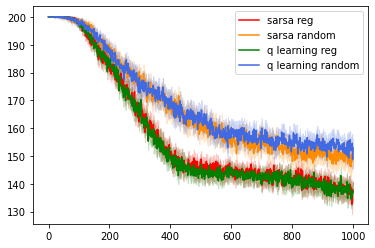

In [ ]:
plt.plot(range(1000), sarsa_regular_mean, label='sarsa reg', color='red')
plt.fill_between(range(1000), sarsa_regular_mean - 2*sarsa_regular_stderr,
                 sarsa_regular_mean + 2*sarsa_regular_stderr, alpha=0.2, color='red')
plt.plot(range(1000), sarsa_random_mean, label='sarsa random', color='darkorange')
plt.fill_between(range(1000), sarsa_random_mean - 2*sarsa_random_stderr,
                 sarsa_random_mean + 2*sarsa_random_stderr, alpha=0.2, color='darkorange')
plt.plot(range(1000), q_regular_mean, label='q learning reg', color='green')
plt.fill_between(range(1000), q_regular_mean - 2*q_regular_stderr,
                q_regular_mean + 2*q_regular_stderr, alpha=0.2, color='green')
plt.plot(range(1000), q_random_mean, label='q learning random', color='royalblue')
plt.fill_between(range(1000), q_random_mean - 2*q_random_stderr,
                q_random_mean + 2*q_random_stderr, alpha=0.2, color='royalblue')
plt.legend()
plt.show()

## Plot Adam runs

In [ ]:
# load result dictionaries
# load result dictionaries
with open('sarsa_adam_regular_mc.p', 'rb') as handle:
    sarsa_adam_regular = pickle.load(handle)

with open('sarsa_adam_random_mc.p', 'rb') as handle:
    sarsa_adam_random = pickle.load(handle)
    
with open('q_adam_regular_mc.p', 'rb') as handle:
    q_adam_regular = pickle.load(handle)
    
with open('q_adam_random_mc.p', 'rb') as handle:
    q_adam_random = pickle.load(handle)

In [ ]:
# create numpy array for sarsa regular
sarsa_adam_regular_array = np.zeros((len(sarsa_adam_regular), len(sarsa_adam_regular[0])))

for i in range(sarsa_adam_regular_array.shape[0]):
    sarsa_adam_regular_array[i] = np.array(sarsa_adam_regular[i])
    
sarsa_adam_random_array = np.zeros((len(sarsa_adam_random), len(sarsa_adam_random[0])))

for i in range(sarsa_adam_random_array.shape[0]):
    sarsa_adam_random_array[i] = np.array(sarsa_adam_random[i])
    
q_adam_regular_array = np.zeros((len(q_adam_regular), len(q_adam_regular[0])))

for i in range(q_adam_regular_array.shape[0]):
    q_adam_regular_array[i] = np.array(q_adam_regular[i])
    
q_adam_random_array = np.zeros((len(q_adam_random), len(q_adam_random[0])))

for i in range(q_adam_random_array.shape[0]):
    q_adam_random_array[i] = np.array(q_adam_random[i])

In [ ]:
# get average for each episode
sarsa_adam_regular_mean = np.mean(sarsa_adam_regular_array, axis=0)
sarsa_adam_regular_stderr = np.std(sarsa_adam_regular_array, axis=0) / np.sqrt(sarsa_adam_regular_array.shape[0])

sarsa_adam_random_mean = np.mean(sarsa_adam_random_array, axis=0)
sarsa_adam_random_stderr = np.std(sarsa_adam_random_array, axis=0) / np.sqrt(sarsa_adam_random_array.shape[0])

q_adam_regular_mean = np.mean(q_adam_regular_array, axis=0)
q_adam_regular_stderr = np.std(q_adam_regular_array, axis=0) / np.sqrt(q_adam_regular_array.shape[0])

q_adam_random_mean = np.mean(q_adam_random_array, axis=0)
q_adam_random_stderr = np.std(q_adam_random_array, axis=0) / np.sqrt(q_adam_random_array.shape[0])

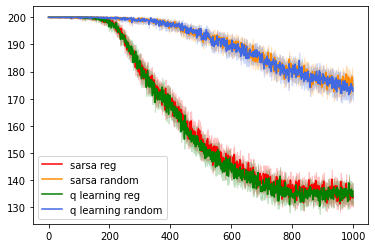

In [ ]:
plt.plot(range(1000), sarsa_adam_regular_mean, label='sarsa reg', color='red')
plt.fill_between(range(1000), sarsa_adam_regular_mean - 2*sarsa_adam_regular_stderr,
                 sarsa_adam_regular_mean + 2*sarsa_adam_regular_stderr, alpha=0.2, color='red')
plt.plot(range(1000), sarsa_adam_random_mean, label='sarsa random', color='darkorange')
plt.fill_between(range(1000), sarsa_adam_random_mean - 2*sarsa_adam_random_stderr,
                 sarsa_adam_random_mean + 2*sarsa_adam_random_stderr, alpha=0.2, color='darkorange')
plt.plot(range(1000), q_adam_regular_mean, label='q learning reg', color='green')
plt.fill_between(range(1000), q_adam_regular_mean - 2*q_adam_regular_stderr,
                q_adam_regular_mean + 2*q_adam_regular_stderr, alpha=0.2, color='green')
plt.plot(range(1000), q_adam_random_mean, label='q learning random', color='royalblue')
plt.fill_between(range(1000), q_adam_random_mean - 2*q_adam_random_stderr,
                q_adam_random_mean + 2*q_adam_random_stderr, alpha=0.2, color='royalblue')
plt.legend()
plt.show()

## Longer runs

In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1500}

sarsa_run_steps_1500 = run_agent(SarsaAgent, agent_info, run_info)

filehandle = open('sarsa_fixed_alpha_regular_mc_1500.p', 'wb')
pickle.dump(sarsa_run_steps_1500, filehandle)

Runs: 100%|██████████| 200/200 [2:33:03<00:00, 45.92s/it]  


In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1500}

sarsa_run_steps_random_1500 = run_agent_random(SarsaAgent, agent_info, run_info)

filehandle = open('sarsa_fixed_alpha_random_mc_1500.p', 'wb')
pickle.dump(sarsa_run_steps_random_1500, filehandle)

Runs: 100%|██████████| 200/200 [2:51:10<00:00, 51.35s/it]  


In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1500}

q_run_steps_1500 = run_agent(QlearningAgent, agent_info, run_info)

filehandle = open('q_fixed_alpha_regular_mc_1500.p', 'wb')
pickle.dump(q_run_steps_1500, filehandle)

Runs: 100%|██████████| 200/200 [2:32:04<00:00, 45.62s/it]  


In [ ]:
agent_info = {'epsilon': 0.1,
              'gamma': 1.0,
              'alpha': 0.1/8,
              'num_actions': 3,
              'num_tiles': 8,
              'num_tilings': 8}

run_info = {'num_runs': 200,
            'max_steps': 200,
            'num_episodes': 1500}

q_run_steps_random_1500 = run_agent_random(QlearningAgent, agent_info, run_info)

filehandle = open('q_fixed_alpha_random_mc_1500.p', 'wb')
pickle.dump(q_run_steps_random_1500, filehandle)

Runs: 100%|██████████| 200/200 [3:05:12<00:00, 55.56s/it]  


## Plot longer runs

In [ ]:
# load result dictionaries
with open('sarsa_fixed_alpha_regular_mc_1500.p', 'rb') as handle:
    sarsa_regular_1500 = pickle.load(handle)

with open('sarsa_fixed_alpha_random_mc_1500.p', 'rb') as handle:
    sarsa_random_1500 = pickle.load(handle)
    
with open('q_fixed_alpha_regular_mc_1500.p', 'rb') as handle:
    q_regular_1500 = pickle.load(handle)
    
with open('q_fixed_alpha_random_mc_1500.p', 'rb') as handle:
    q_random_1500 = pickle.load(handle)

In [ ]:
sarsa_regular_array_1500 = np.zeros((len(sarsa_regular_1500), len(sarsa_regular_1500[0])))

for i in range(sarsa_regular_array_1500.shape[0]):
    sarsa_regular_array_1500[i] = np.array(sarsa_regular_1500[i])

sarsa_random_array_1500 = np.zeros((len(sarsa_random_1500), len(sarsa_random_1500[0])))

for i in range(sarsa_random_array_1500.shape[0]):
    sarsa_random_array_1500[i] = np.array(sarsa_random_1500[i])
    
q_regular_array_1500 = np.zeros((len(q_regular_1500), len(q_regular_1500[0])))

for i in range(q_regular_array_1500.shape[0]):
    q_regular_array_1500[i] = np.array(q_regular_1500[i])
    
q_random_array_1500 = np.zeros((len(q_random_1500), len(q_random_1500[0])))

for i in range(q_random_array_1500.shape[0]):
    q_random_array_1500[i] = np.array(q_random_1500[i])

In [ ]:
sarsa_regular_mean_1500 = np.mean(sarsa_regular_array_1500, axis=0)
sarsa_regular_stderr_1500 = np.std(sarsa_regular_array_1500, axis=0) / np.sqrt(sarsa_regular_array_1500.shape[0])

sarsa_random_mean_1500 = np.mean(sarsa_random_array_1500, axis=0)
sarsa_random_stderr_1500 = np.std(sarsa_random_array_1500, axis=0) / np.sqrt(sarsa_random_array_1500.shape[0])

q_regular_mean_1500 = np.mean(q_regular_array_1500, axis=0)
q_regular_stderr_1500 = np.std(q_regular_array_1500, axis=0) / np.sqrt(q_regular_array_1500.shape[0])

q_random_mean_1500 = np.mean(q_random_array_1500, axis=0)
q_random_stderr_1500 = np.std(q_random_array_1500, axis=0) / np.sqrt(q_random_array_1500.shape[0])

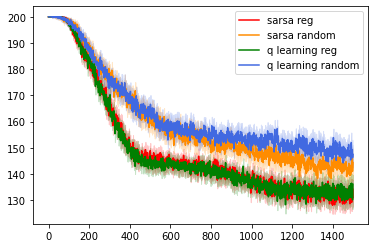

In [ ]:
plt.plot(range(1500), sarsa_regular_mean_1500, label='sarsa reg', color='red')
plt.fill_between(range(1500), sarsa_regular_mean_1500 - 2*sarsa_regular_stderr_1500,
                 sarsa_regular_mean_1500 + 2*sarsa_regular_stderr_1500, alpha=0.2, color='red')
plt.plot(range(1500), sarsa_random_mean_1500, label='sarsa random', color='darkorange')
plt.fill_between(range(1500), sarsa_random_mean_1500 - 2*sarsa_random_stderr_1500,
                 sarsa_random_mean_1500 + 2*sarsa_random_stderr_1500, alpha=0.2, color='darkorange')
plt.plot(range(1500), q_regular_mean_1500, label='q learning reg', color='green')
plt.fill_between(range(1500), q_regular_mean_1500 - 2*q_regular_stderr_1500,
                q_regular_mean_1500 + 2*q_regular_stderr_1500, alpha=0.2, color='green')
plt.plot(range(1500), q_random_mean_1500, label='q learning random', color='royalblue')
plt.fill_between(range(1500), q_random_mean_1500 - 2*q_random_stderr_1500,
                q_random_mean_1500 + 2*q_random_stderr_1500, alpha=0.2, color='royalblue')
plt.legend()
plt.show()